In [1]:
# Important libraries

import numpy as np
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
np.random.seed(4440)

In [24]:
# Functions

def random_position(radius, center=(0,0)):
    angle = np.random.uniform(0, 2*np.pi)
    x = round(radius*np.cos(angle))
    y = round(radius*np.sin(angle))
    return [center[0]+x, center[1]+y]


def new_position(position):
    direction = np.random.rand()
    if direction < 1/4: position[0] -= 1
    elif direction < 2/4: position[0] += 1
    elif direction < 3/4: position[1] -= 1
    else: position[1] += 1
    return position


def least_squares_regression(x, y):
    x = np.log(x)
    y = np.log(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    a = ((x - mean_x)*(y - mean_y)).sum()/((x - mean_x)**2).sum()
    b = mean_y - a * mean_x
    
    fit_data = a*x + b
    print(f'y = {a:.3f}*x {"+" if (b > 0) else "-"} {abs(b):.3f}\n\n')
    
    sns.scatterplot(x=x, y=y)
    sns.lineplot(x=x, y=fit_data)
    plt.xlabel('ln(L)')
    plt.ylabel('ln(M)')
    plt.show()


def visualization(field, radius):
    grid = field.shape
    center = (round((grid[0]-1)/2), round((grid[0]-1)/2))
    field[field == -1] = 0
    
    y = lambda x: np.sqrt(radius**2 - x**2)
    x = np.linspace(-radius,radius, 4*int(radius))
    
    cmap = mpl.colormaps['Dark2'].resampled(256)
    newcolors = cmap(np.linspace(0, 1, 256))
    background = np.array([0.1, 0.1, 0.1, 1])
    newcolors = np.vstack((background,newcolors)) 
    newcmp = mpl.colors.ListedColormap(newcolors)
    
    sns.lineplot(x=x+center[0], y=-y(x)+center[1], color='violet')
    sns.lineplot(x=x+center[0], y=y(x)+center[1], color='violet')
    sns.heatmap(field, cmap=newcmp, cbar=False)
    plt.axis('off')
    plt.xlim([0,grid[0]])
    plt.ylim([0,grid[1]])
    plt.show()

time = 1085 sec
Particles 11261

y = 1.692*x + 2.839




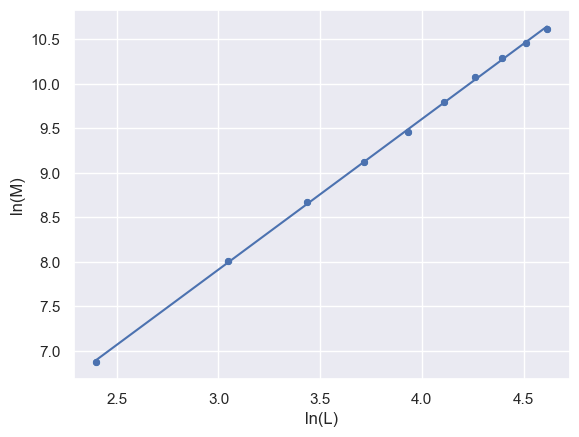

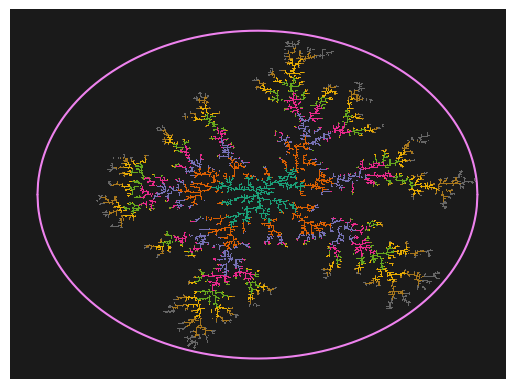

In [27]:
# Simulation

N = 20
radius = 200
safe_ratio = 1.125
safety_factor = 200
particles_per_level = 500
neighborhood = "Von Neumann"

half_Ls = np.arange(5, 50+1, 5)
M = np.zeros(len(half_Ls))

start = time.time()

if neighborhood == 'Moore': scaling_constant = np.sqrt(2)
elif neighborhood == 'Von Neumann': scaling_constant = 1
    
safe_radius = np.ceil(safe_ratio*radius).astype(int)
grid = np.array((2*safe_radius+1, 2*safe_radius+1))
center = (round((grid[0]-1)/2), round((grid[0]-1)/2))

field = np.zeros(grid)
field[center] = 1

if neighborhood == 'Moore':
    field[center[0]-1:center[0]+2, center[1]-1:center[1]+2][field \
         [center[0]-1:center[0]+2, center[1]-1:center[1]+2] == 0] = -1
elif neighborhood == 'Von Neumann':
    field[(center[0],center[0]-1,center[0],center[0]+1), 
          (center[1]-1,center[1],center[1]+1,center[1])] = -1

particles = 1
max_dist = 0
current_radius = radius if scaling_constant*safety_factor > radius \
                        else scaling_constant*safety_factor
current_safe_radius = safe_ratio*current_radius

while max_dist < radius:
    position = random_position(current_radius, center=center)
    
    while True:
        dist = np.sqrt((position[0] - center[0])**2 + (position[1] - center[1])**2)

        if dist > current_safe_radius: break
        elif field[position[0], position[1]] == -1:
            field[position[0],position[1]] = particles//particles_per_level +1
            particles += 1

            if neighborhood == 'Moore':
                field[position[0]-1:position[0]+2, position[1]-1:position[1]+2][field \
                     [position[0]-1:position[0]+2, position[1]-1:position[1]+2] == 0] = -1
            elif neighborhood == 'Von Neumann':
                field[position[0]-1:position[0]+2:2, position[1]][field[position[0]-1:position[0]+2:2, position[1]] == 0] = -1
                field[position[0], position[1]-1:position[1]+2:2][field[position[0], position[1]-1:position[1]+2:2] == 0] = -1
            
            if dist > max_dist: 
                max_dist = dist
                
                if current_radius < radius:                    
                    current_radius = max_dist + scaling_constant*safety_factor
                    
                    if current_radius > radius: current_radius = radius
                    current_safe_radius = safe_ratio*current_radius
            break
        else: position = new_position(position)

for i in range(1, N+1):
    new_center = center + np.random.randint(0,10+1,2)
    
    for num,L in enumerate(half_Ls):
        M[num] += (field[new_center[0]-L:new_center[0]+L+1, new_center[1]-L:new_center[1]+L+1] >= 1).sum()

print(f'time = {round(time.time() - start)} sec')
print("Particles", particles)
print()
least_squares_regression(x=2*half_Ls+1, y=M)
visualization(field=field, radius=radius)